# Домашнее задание. Титаник
В этом домашнем задании вам предлагается решить задачу предсказания выживших пассажиров Титаника. Эту задачу машинного обучения рано или поздно решает, наверное, любой, кто обучается анализу данных. Информация о датасете доступна по <a href=https://www.kaggle.com/c/titanic.>ссылке</a>.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Загрузка данных

Загрузим датасет Titanic из приложенных файлов. В первом файле находится информация о пассажирах, во втором -- информация о том, выжил пассажир или нет.

Если вы запускаете ноутбук на Google Colab, самым простым способом загрузить данные в ноутбук будет примонтировать к Colab ваш Google Drive. Для этого сначала положите в свою корневую директорию Google Drive  файлы, приложенные к этому ноутбуку, а затем выполните три закоментированные строчки в клетке ниже. <a href=https://www.machinelearningmastery.ru/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166/>Подробная инструкция по работе с Google Drive + Google Colab</a>

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#data = pd.read_csv('/content/gdrive/My Drive/titanic_data.csv, index_col='PassengerId')

#Если запускаете ноутбук локально:
data = pd.read_csv('titanic_data.csv', index_col='PassengerId')

In [3]:
basic_features = data.columns

y = pd.read_csv('titanic_surv.csv')
y.index = data.index

print(f'Всего {len(data)} пассажиров в выборке')
data.head()

Всего 891 пассажиров в выборке


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
y.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [5]:
data = data.join(y)
data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


## Исследование датасета

### Задание 1 (1 балл)
Опишите датасет. Сколько в нём мужчин, сколько женщин? Посчитайте распределение по классам пассажиров. Используйте функцию ``pd.Series.value_counts``. <a href=https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.value_counts.html>Пример использования</a>

Посчитайте долю выживших мужчин к общему количеству мужчин, а также женщин к общему количеству женщин. Сделайте выводы. 
Проведите схожую аналитику по возрасту выживших и по классу выживших. 

Вам поможет функция ``plt.hist()``. <a href=https://matplotlib.org/3.3.1/gallery/pyplots/pyplot_text.html#sphx-glr-gallery-pyplots-pyplot-text-py> Пример использования </a> 

### Кол-во мужчин и женщин в датасете

male      577
female    314
Name: Sex, dtype: int64


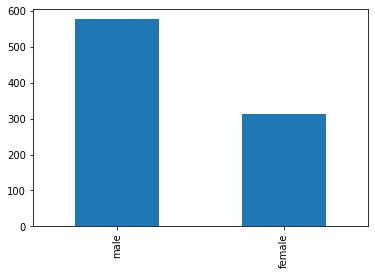

In [6]:
print(data.Sex.value_counts())
data.Sex.value_counts().plot(kind='bar')

### Распределение по классам пассажиров

1    216
2    184
3    491
Name: Pclass, dtype: int64


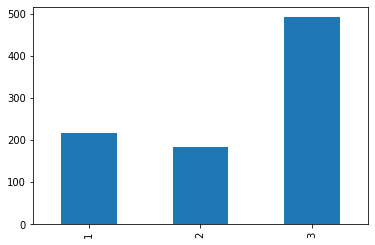

In [7]:
print(data.Pclass.value_counts().sort_index())
data.Pclass.value_counts().sort_index().plot(kind='bar')

## Доли выживших и погибших пассажиров

### По полу

,Sex,Survived,Доля
0,female,1,0.742038
1,female,0,0.257962
2,male,0,0.811092
3,male,1,0.188908


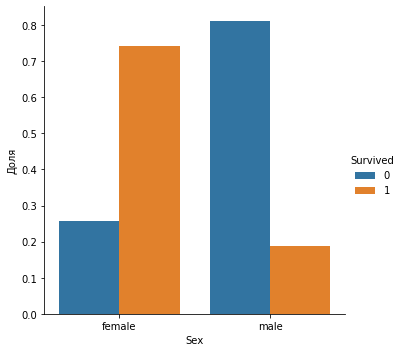

In [111]:
group_survive_sex = data.groupby('Sex')['Survived'].value_counts(normalize=True)

group_survive_sex = group_survive_sex.reset_index(name='Доля')

sns.catplot(x='Sex', y='Доля', kind='bar', hue='Survived', data=group_survive_sex)

group_survive_sex

## Заполнение пропусков в данных
В данных имеются пропуски в трёх колонках: 

In [6]:
data.columns[data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

Для простоты заполним все пропуски в категориальных колонках новым классом "0", а в числовой колонке Age --- медианным значением. 

In [16]:
data.loc[:, ['Cabin', 'Embarked']] = data.loc[:, ['Cabin', 'Embarked']].fillna('0')
data['Age'] = data['Age'].fillna(data['Age'].median())

## Подготовка плана тестирования

### Задание 2. (0 баллов)
Разделите выборку на обучающее и тестовое множество в соотношении 70:30.

In [ ]:
from sklearn.model_selection import train_test split
data_train, data_test = <YOUR CODE>

## Выделение новых признаков
Теперь отложим тестовые данные и приступим к моделированию. Внимательно изучите данные. Можете ли вы выделить признаки, которые не указаны явно в таблице?

### Задание 3 (1 балл)
 Сформируйте по крайней мере один новый признак и объясните ваш выбор. Пример признака сформирован за вас. 

Указания: 
- Пассажиров можно поделить на несколько классов по их именам.
- Различных номеров кают слишком много. Но буквы в номерах кают указывают на их местоположение. (***Этот признак сформирован в примере***)
- Возможно, имеет смысл отделить мальчиков от мужчин. Отделять девочек от женщин может быть не так важно
- Другие идеи для признаков можно почерпнуть на форуме в обсуждении задачи на kaggle.com.

In [14]:
data

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0


In [17]:
data['Cabin']

PassengerId
1         0
2       C85
3         0
4      C123
5         0
       ... 
887       0
888     B42
889       0
890    C148
891       0
Name: Cabin, Length: 891, dtype: object

In [18]:
def get_cabin_letter(row):
    return row['Cabin'][0]

data_train['cabin_type'] = data_full.apply(get_cabin_letter, axis=1)

Сюда добавьте описание вашего нового признака

In [19]:
def compute_my_feature(row): #rename this function appropriately
    return <YOUR CODE>

data_full[<NEW FEATURE NAME>] = <YOUR CODE> 

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,cabin_type
PassengerId,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,1,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,C
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S,0,0
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1,B
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23.4500,0,S,0,0


## Кодирование категориальных признаков и обработка данных
Все признаки сейчас делятся на числовые, бинарные, категориальные и текстовые. К текстовым признакам можно отнести имя пассажира, номер билета и номер каюты: значения этих признаков уникальны почти для всех пассажиров, и простого способа использовать их в модели не существует.

### Задание 4 (0 баллов)
Пока используя только изначальные признаки, перекодируйте категориальные признаки функцией ``pd.get_dummies``. Естественно, имена пассажиров и номера билетов и кают кодировать не стоит, поскольку все значения этих признаков уникальные. 

In [ ]:
<YOUR CODE>

## Обучение baseline-модели

### Задание 5 (1 балл)

Обучите одну из простых известных вам моделей. Измерьте качество полученной модели на кросс-валидации (используйте только обучающую выборку!)

In [ ]:
<YOUR CODE>

### Задание 6 (1 балл)
Добавьте в модель два новых сгенерированных признака. Если нужно, добавьте признаки, сгенерированные ohe-hot кодированием. Обучите ту же самую модель на расширенном множестве признаков. Улучшилось ли качество предсказания на кросс-валидации?

In [ ]:
<YOUR CODE>

## Дополнительное моделирование
### Задание 7 (2 балла)
Теперь более серьёзно подойдём к моделированию. Попробуйте несколько алгоритмов из тех, что мы проходили в курсе. Вам помогут ноутбуки с линейными алгоритмами и выбором модели. Хотя бы для одного алгоритма проведите подбор оптимального гиперпараметра. 

In [ ]:
<YOUR CODE>

## Результаты моделирования

### Задание 8 (1 балл)
Измерьте качество итоговой модели на кросс-валидации. Выполните предсказание на тестовом множестве и сохраните их в переменную ``y_test``. Измерьте итоговое качество на тестовом множестве.

In [ ]:
<YOUR CODE>

## Выводы
### Задание 9 (3 балла)
Сделайте выводы. Какие из идей сработали? Какие оказались лишними?